In [3]:
#Resource
#https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%202%20-%20Case%20Studies.ipynb
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [4]:
#Resource
#https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%202%20-%20Case%20Studies.ipynb
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

In [26]:
#Load data
dataset=pd.read_csv('C:\\Users\\sagi\\Desktop\\Learning\\ML\\Datasets\\bill_authentication.csv')
dataset.shape
dataset.info

<bound method DataFrame.info of       Variance  Skewness  Curtosis  Entropy  Class
0         3.62      8.67     -2.81    -0.45      0
1         4.55      8.17     -2.46    -1.46      0
2         3.87     -2.64      1.92     0.11      0
3         3.46      9.52     -4.01    -3.59      0
4         0.33     -4.46      4.57    -0.99      0
5         4.37      9.67     -3.96    -3.16      0
6         3.59      3.01      0.73     0.56      0
7         2.09     -6.81      8.46    -0.60      0
8         3.20      5.76     -0.75    -0.61      0
9         1.54      9.18     -2.27    -0.74      0
10        1.22      8.78     -2.21    -0.81      0
11        3.99     -2.71      2.39     0.86      0
12        1.90      7.66      0.15    -3.11      0
13       -1.58     10.84      2.55    -2.94      0
14        3.40      8.73     -2.99    -0.57      0
15        4.68     -3.39      3.49     1.48      0
16        2.67      3.06      0.37     0.59      0
17        0.80      2.85      4.34     0.60      0

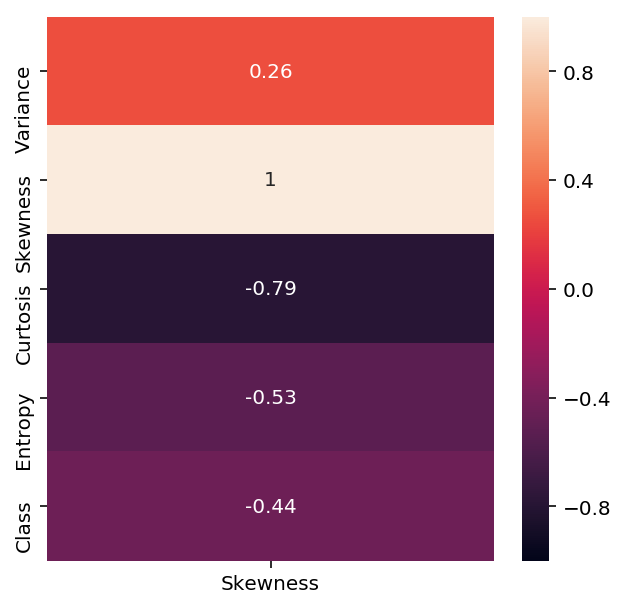

In [19]:
#check the correlation of the features with 'Skewness' 
plt.figure(figsize=(5, 5))
sns.heatmap(dataset.corr()[['Skewness']], annot=True, vmin=-1, vmax=1)

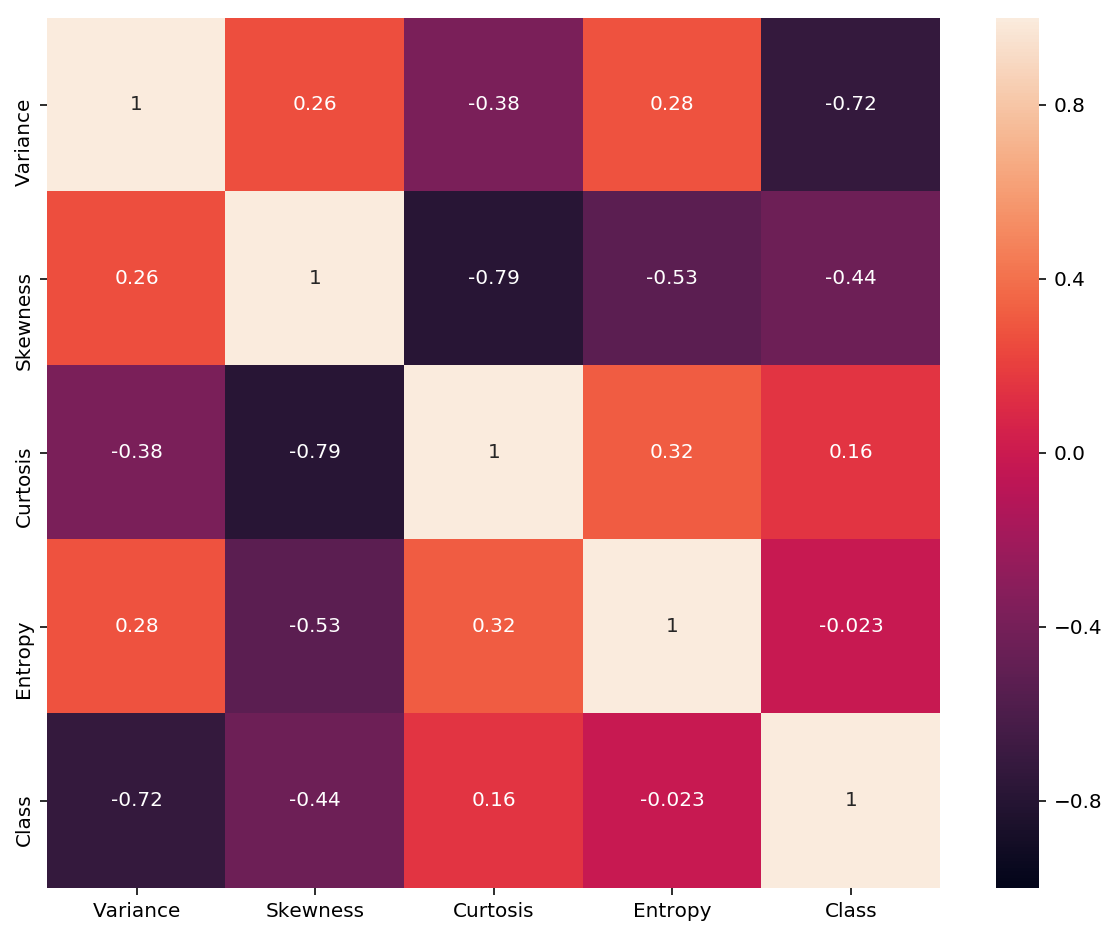

In [21]:
#check the correlation of the features with each other
plt.figure(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, vmin=-1, vmax=1)

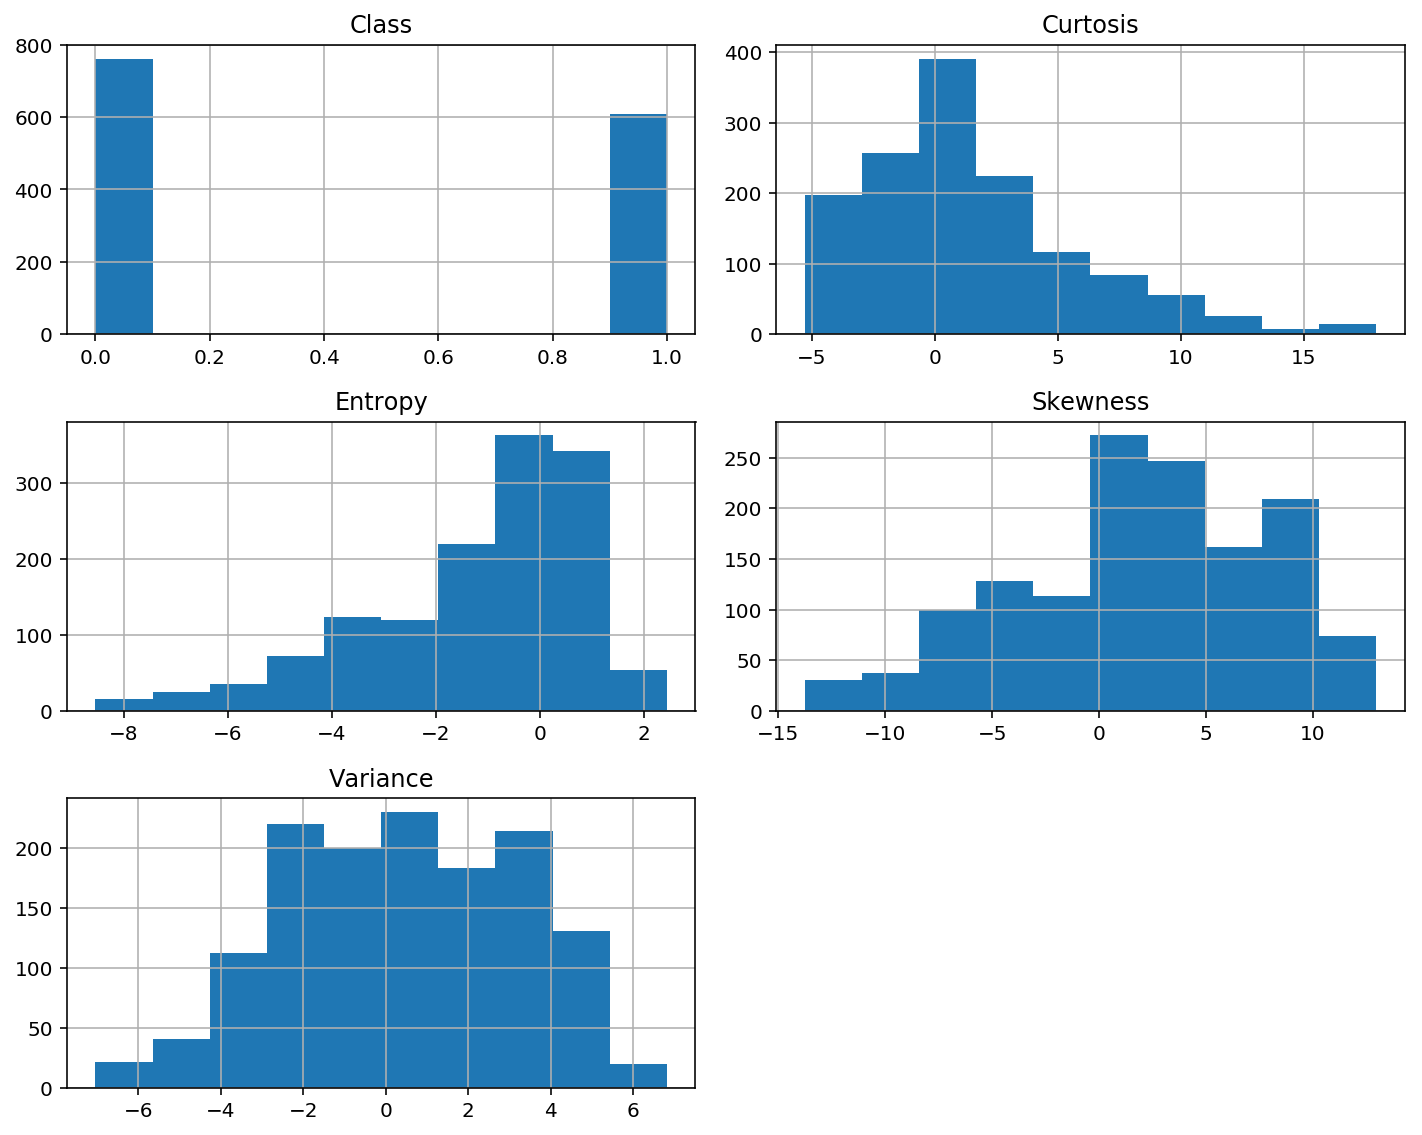

In [23]:
#Distribution of feature values
dataset.hist(figsize=(10,8))
plt.tight_layout()

In [25]:
#Copy and Normalize
df=dataset.copy()
ss=StandardScaler()
scale_features=['Skewness','Curtosis','Entropy','Variance']
df[scale_features] = ss.fit_transform(df[scale_features])

In [37]:
#creating the training and testing
x=dataset.iloc[:, :4].values #convert data from pandas dataframe to numpy array using the values
y=dataset.iloc[:,4].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1097, 4) (1097,) (275, 4) (275,)


Epoch 1/50
1097/1097 [==============================] - 1s 462us/step - loss: 2.0208 - acc: 0.5269
Epoch 2/50
1097/1097 [==============================] - 0s 38us/step - loss: 0.7584 - acc: 0.7284
Epoch 3/50
1097/1097 [==============================] - 0s 39us/step - loss: 0.4592 - acc: 0.8104
Epoch 4/50
1097/1097 [==============================] - 0s 40us/step - loss: 0.3374 - acc: 0.8478
Epoch 5/50
1097/1097 [==============================] - 0s 39us/step - loss: 0.2672 - acc: 0.8797
Epoch 6/50
1097/1097 [==============================] - 0s 39us/step - loss: 0.2197 - acc: 0.9125
Epoch 7/50
1097/1097 [==============================] - 0s 55us/step - loss: 0.1860 - acc: 0.9344
Epoch 8/50
1097/1097 [==============================] - 0s 50us/step - loss: 0.1612 - acc: 0.9544
Epoch 9/50
1097/1097 [==============================] - 0s 43us/step - loss: 0.1410 - acc: 0.9672
Epoch 10/50
1097/1097 [==============================] - 0s 39us/step - loss: 0.1259 - acc: 0.9708
Epoch 11/50
1097/1

<Figure size 576x432 with 0 Axes>

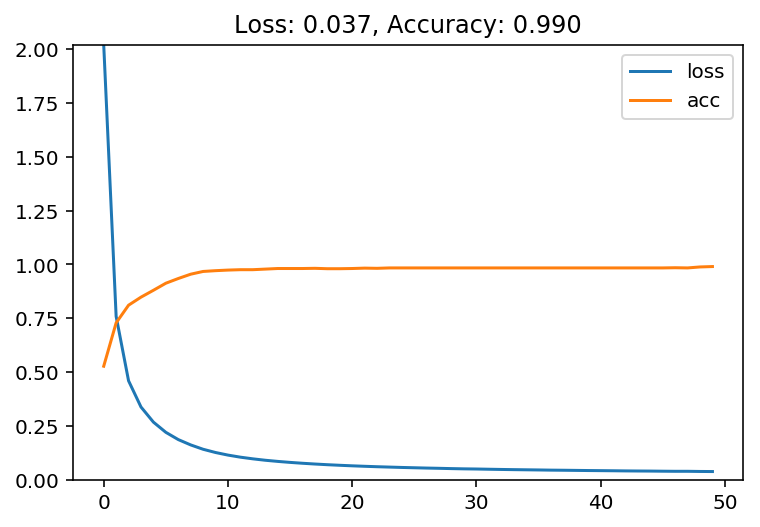

In [48]:
#Logistic Regression Model

#define model
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(x_train.shape[1],), activation='sigmoid'))

#compile
lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

#fit
lr_history = lr_model.fit(x_train, y_train, verbose=1, epochs=50)
plot_loss_accuracy(lr_history)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       157
           1       0.98      1.00      0.99       118

   micro avg       0.99      0.99      0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



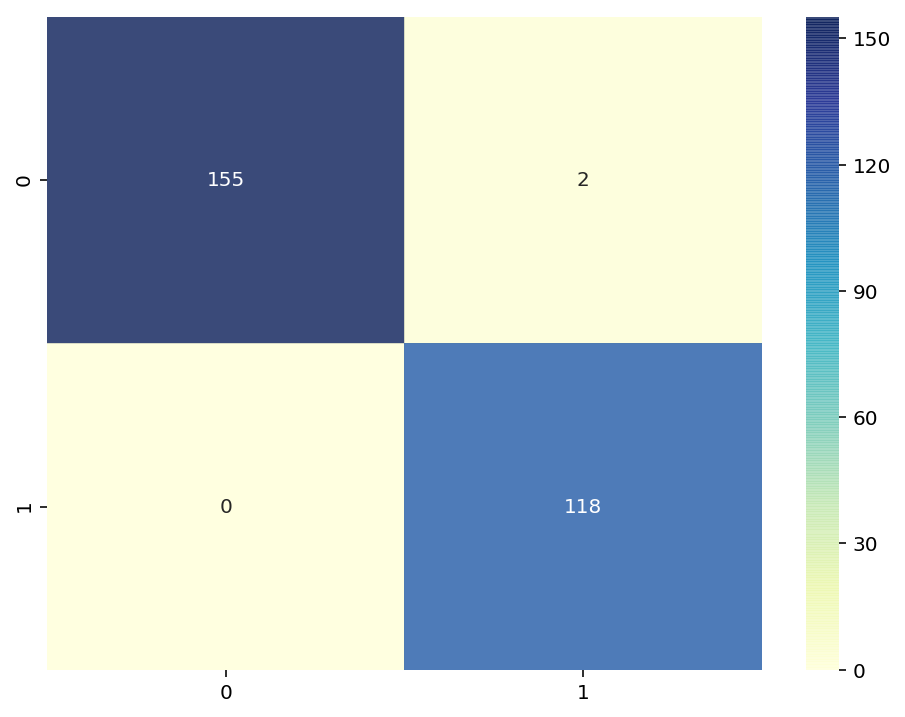

In [49]:
#predict
y_pred = lr_model.predict_classes(x_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, x_test, y_test)

<Figure size 576x432 with 0 Axes>

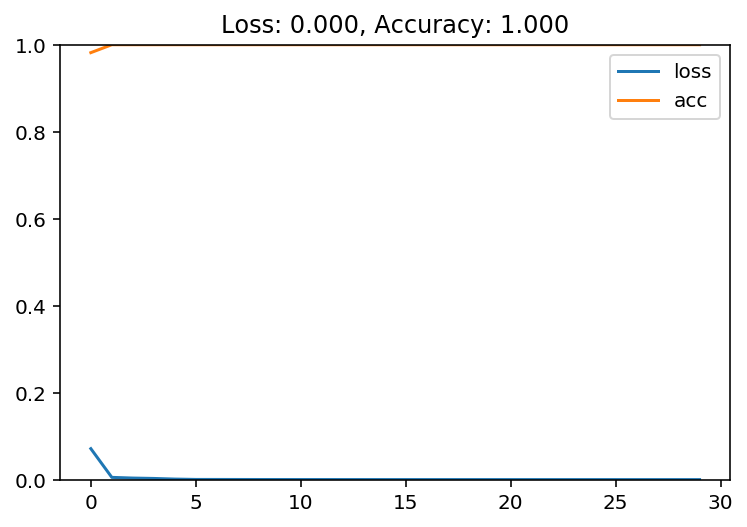

In [50]:
#ANN Model
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(x_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(x_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       157
           1       1.00      1.00      1.00       118

   micro avg       1.00      1.00      1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



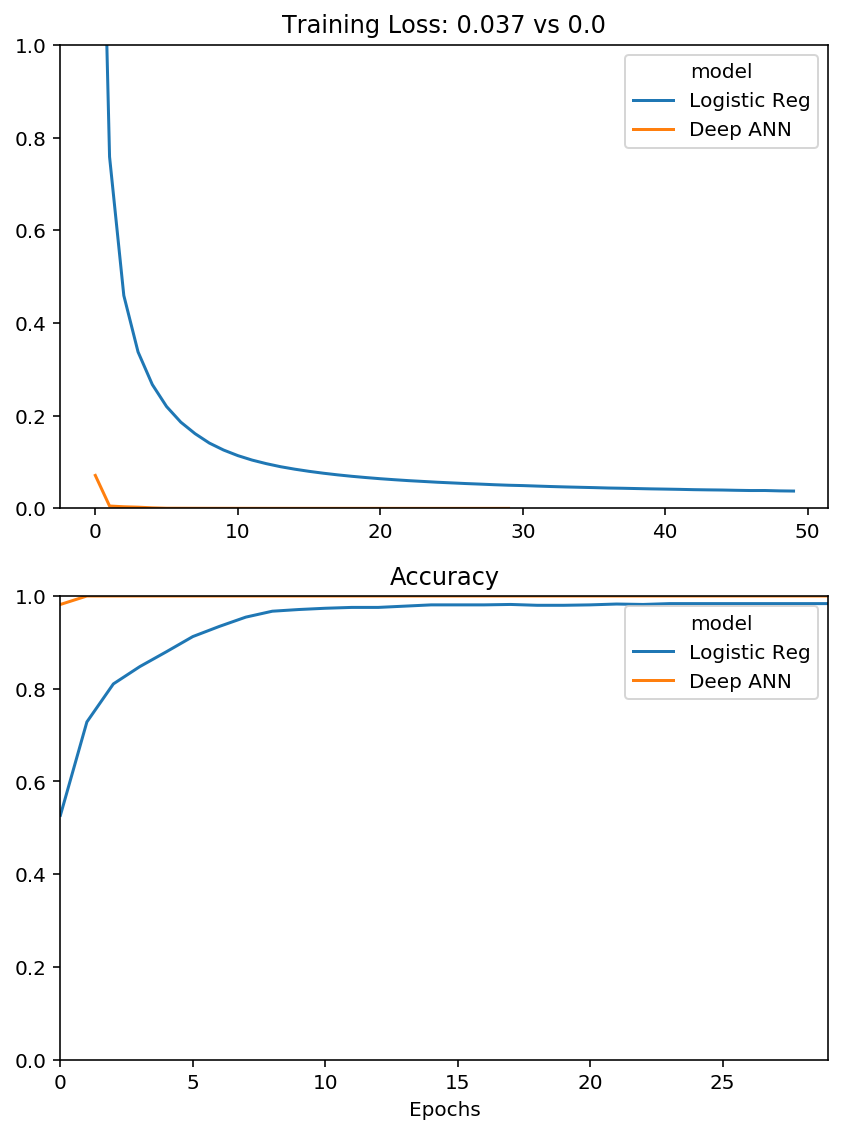

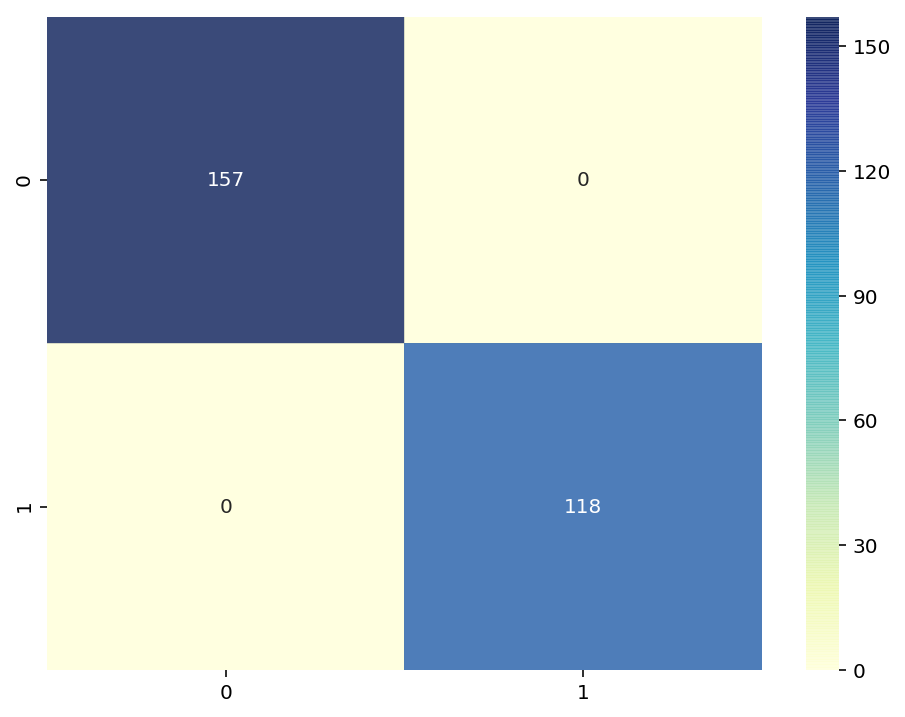

In [53]:
#Comparing results between LR and ANN
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep ANN'])
y_pred = deep_model.predict_classes(x_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, x_test, y_test)

Text(0.5, 1.0, 'Test Data Separation')

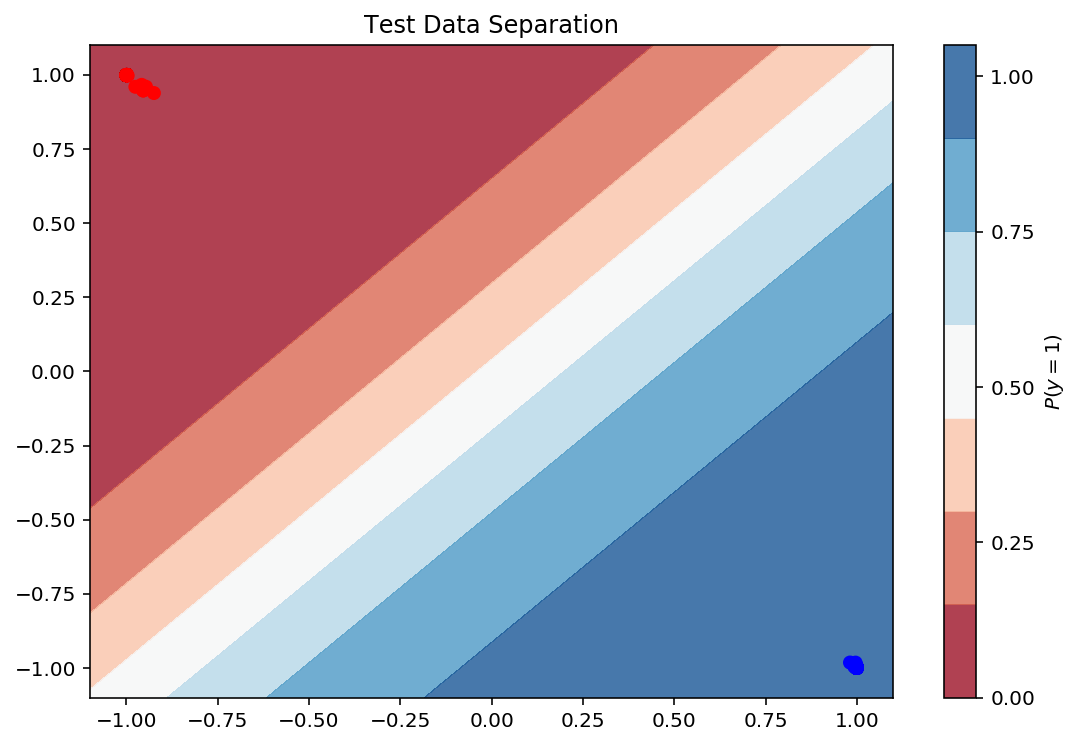

In [55]:
#Deep Model Visualization
# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[2].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[3].input
out2 = deep_model_vis.layers[3].output
func2 = K.function([inp2], [out2])

features = func1([x_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

In [ ]:
#Resources
#https://towardsdatascience.com/applied-deep-learning-part-2-real-world-case-studies-1bb4b142a585